<a href="https://colab.research.google.com/github/ortrsa/final-project/blob/main/final_project_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final project - Breast Lesion Analysis using U-NET 

### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

import torch
import torchvision
from torch.utils.data import DataLoader

import torch.nn as nn
import torchvision.transforms.functional as TF

from pickle import TUPLE
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2
import albumentations as A
from tqdm import tqdm
import torch.optim as optim

import cv2
import numpy as np

from google.colab.patches import cv2_imshow


Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 4.0 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=6fed322a206b599eeda14629f993afddc0fe73cba65302da1597e4a4b316d88f
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


## Creating Dataset object

In [2]:
# create new Dataset
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        #Transform image and mask
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask



## Utils functions

In [3]:

def save_checkpoint(state, filename="/content/drive/MyDrive/final project/my_checkpoint.pth.tar"):
    print("Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    pred_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4, 
    pin_memory=True,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    pred_ds = CarvanaDataset(
        image_dir=pred_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    pred_loader = DataLoader(
        pred_ds,
        batch_size=1,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )




    return train_loader, val_loader, pred_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-7
            )

    print(
        f"Got acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="/content/drive/MyDrive/final project/saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")
        torchvision.utils.save_image(x, f"{folder}{idx}_org.png")

    model.train()


def predict_img(
    loader, model, folder="/content/drive/MyDrive/final project/predictions/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{folder}/pred.png")
        
    model.train()

## UNET

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList() #save place for submodel
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x) # only ConvTranspose2d (make the image bigger)
            skip_connection = skip_connections[idx//2] # get the skip connection (reversed)

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1) # concat the skip connection
            x = self.ups[idx+1](concat_skip) # DoubleConv

        return self.final_conv(x)


## Hyperparameters

In [5]:
# Hyperparameters 
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 20
NUM_WORKERS = 2
IMAGE_HEIGHT = 128  # 1280 originally
IMAGE_WIDTH = 128  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = "/content/drive/MyDrive/final project/data/train_images/"
TRAIN_MASK_DIR = "/content/drive/MyDrive/final project/data/train_masks/"
VAL_IMG_DIR = "/content/drive/MyDrive/final project/data/val_images/"
VAL_MASK_DIR = "/content/drive/MyDrive/final project/data/val_masks/"
PRED_IMG_DIR = "/content/drive/MyDrive/final project/data/pred_images/"


## Train

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader, _ = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        PRED_IMG_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("/content/drive/MyDrive/final project/temp/אימונים/1.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler() 

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # # save model
        # checkpoint = {
        #     "state_dict": model.state_dict(),
        #     "optimizer":optimizer.state_dict(),
        # }
        # save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="/content/drive/MyDrive/final project/saved_images/", device=DEVICE
        )


if __name__ == "__main__":
    main()

Loading checkpoint
Got acc 96.66
Dice score: 0.5026373267173767


100%|██████████| 35/35 [00:04<00:00,  7.38it/s, loss=0.243]


Got acc 96.31
Dice score: 0.49021974205970764


In [ ]:
# Predict from pred folder
val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

train_loader, val_loader, pred_loader= get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    PRED_IMG_DIR,
    1,
    val_transforms,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY,
)
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
load_checkpoint(torch.load("/content/drive/MyDrive/final project/my_checkpoint.pth.tar"), model)


predict_img(pred_loader, model, device=DEVICE)
print(f"save to folder" )

Loading checkpoint
save to folder


Model prediction: 


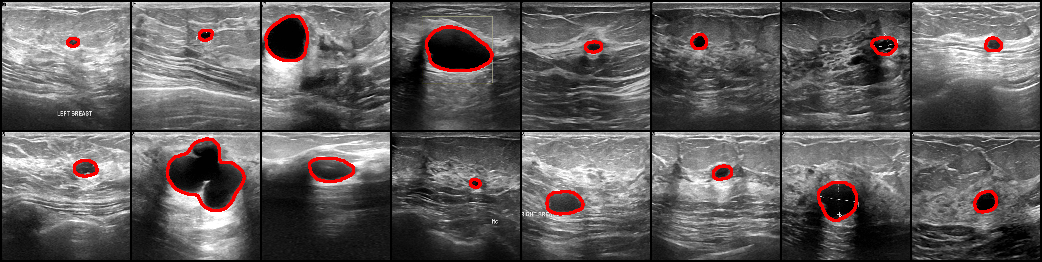

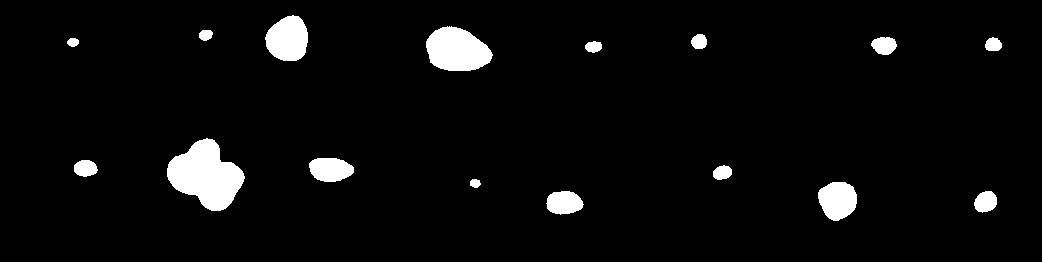

Dataset labeling:


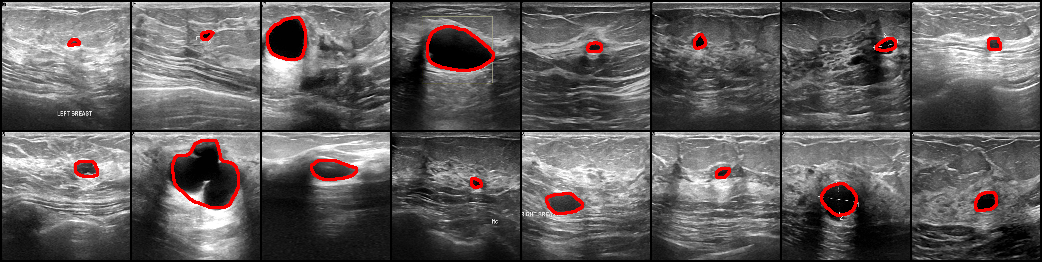

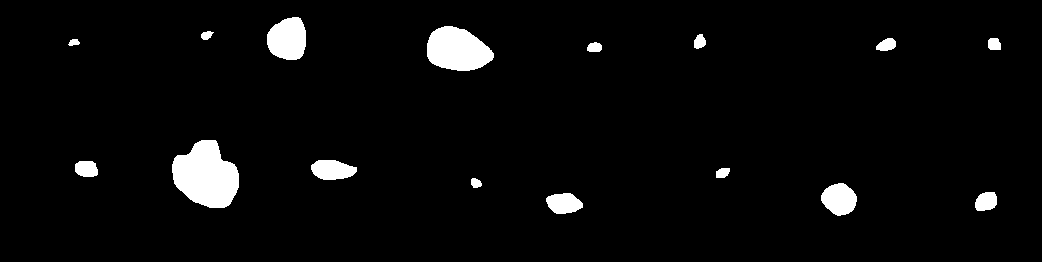

-1

In [6]:
im_num = 0
image = cv2.imread(f'/content/drive/MyDrive/final project/saved_images/pred_{im_num}.png')
image1 = cv2.imread(f'/content/drive/MyDrive/final project/saved_images/{im_num}_org.png')
mask = np.ones(image.shape, dtype=np.uint8) * 255
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image1, [c], 0, (0,0,250), thickness=2)
print("Model prediction: ")
cv2_imshow(image1)
cv2.waitKey()

cv2_imshow(image)
cv2.waitKey()


org_image = cv2.imread(f'/content/drive/MyDrive/final project/saved_images/{im_num}.png')
image2 = cv2.imread(f'/content/drive/MyDrive/final project/saved_images/{im_num}_org.png')
mask = np.ones(org_image.shape, dtype=np.uint8) * 255
gray = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)

cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image2, [c], 0, (0,0,250), thickness=2)


print("Dataset labeling:")
cv2_imshow(image2)
cv2.waitKey()

cv2_imshow(org_image)
cv2.waitKey()